#Pré-Processamento

In [1]:
import pandas as pd

# Carregar os dados
data = pd.read_csv('/content/Clean_Dataset.csv', sep=',')

#Exibir os dados
data.head(10)

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
5,5,Vistara,UK-945,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.33,1,5955
6,6,Vistara,UK-927,Delhi,Morning,zero,Morning,Mumbai,Economy,2.08,1,6060
7,7,Vistara,UK-951,Delhi,Afternoon,zero,Evening,Mumbai,Economy,2.17,1,6060
8,8,GO_FIRST,G8-334,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.17,1,5954
9,9,GO_FIRST,G8-336,Delhi,Afternoon,zero,Evening,Mumbai,Economy,2.25,1,5954


In [2]:
# Remover as colunas desnecessárias
df = data.drop(columns=['Unnamed: 0', 'flight'])

In [3]:
# Separar as colunas numéricas e categóricas
categorical_cols = ['airline','source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class']
numerical_cols = ['duration', 'days_left']

In [4]:
from sklearn.preprocessing import OneHotEncoder
# Aplicar OneHotEncoder nas variáveis categóricas
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_categoricals = encoder.fit_transform(df[categorical_cols])

In [5]:
from sklearn.preprocessing import StandardScaler
# Normalizar as variáveis numéricas
scaler = StandardScaler()
scaled_numerics = scaler.fit_transform(df[numerical_cols])

In [6]:
import numpy as np
# Concatenar as variáveis tratadas
X = np.concatenate([encoded_categoricals, scaled_numerics], axis=1)

In [7]:
# Variável alvo
y = df['price'].values

In [8]:
from sklearn.model_selection import train_test_split
# Dvidir os conjuntos de dados
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [9]:
# Normalizar a variável alvo para uniformizar a escala em relação as variáveis independentes
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

In [10]:
import torch
# Converter para tensores PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).view(-1, 1)

In [11]:
# Exibir shapes dos tensores para garantir que tudo está correto
print("X_train shape:", X_train_tensor.shape)
print("X_val shape:", X_val_tensor.shape)
print("X_test shape:", X_test_tensor.shape)
print("y_train shape:", y_train_tensor.shape)
print("y_val shape:", y_val_tensor.shape)
print("y_test shape:", y_test_tensor.shape)

X_train shape: torch.Size([210107, 30])
X_val shape: torch.Size([45023, 30])
X_test shape: torch.Size([45023, 30])
y_train shape: torch.Size([210107, 1])
y_val shape: torch.Size([45023, 1])
y_test shape: torch.Size([45023, 1])


#Definição do Modelo

In [12]:
import torch.nn as nn
# Definindo arquitetura do modelo

class MLPRegressionModel(nn.Module):
  def __init__(self, input_dim):
    super(MLPRegressionModel, self).__init__()
    self.fc1 = nn.Linear(input_dim, 128)
    self.relu1 = nn.ReLU()
    self.dropout1 = nn.Dropout(0.3)

    self.fc2 = nn.Linear(128, 64)
    self.relu2 = nn.ReLU()
    self.dropout2 =  nn.Dropout(0.3)

    self.fc3 = nn.Linear(64, 32)
    self.relu3 = nn.ReLU()

    self.fc4 = nn.Linear(32, 1)

  def forward(self, x):
    x = self.fc1(x)
    x = self.relu1(x)
    x = self.dropout1(x)

    x = self.fc2(x)
    x = self.relu2(x)
    x = self.dropout2(x)

    x = self.fc3(x)
    x = self.relu3(x)

    x = self.fc4(x)
    return x

In [13]:
import torch.optim as optim
# Definindo modelo, critério e otimizador
input_dim = X_train_tensor.shape[1]
model = MLPRegressionModel(input_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [14]:
# Função para calcular o valor percentual do erro médio absoluto (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
  epsilon = 1e-8
  return torch.mean(torch.abs((y_true - y_pred) / (y_true + epsilon))) * 100

In [15]:
# Função para calcular a acurácia
def accuracy_within_tolerance(y_true, y_pred, tolerance=0.1):
    diff = torch.abs((y_true - y_pred) / y_true)
    correct = torch.sum(diff < tolerance)
    return correct.item() / len(y_true)

In [16]:
from torch.utils.data import DataLoader, TensorDataset
# Definir DataLoader para dividir os dados em mini-batches e facilitar o gerenciamento do loop de treinamento
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [17]:
# Loop de treinamento
epochs = 100

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    # Treinamento por mini-batches
    for X_batch, y_batch in train_loader:
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass e otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validação após cada época
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_mape = mean_absolute_percentage_error(y_val_tensor, val_outputs)
        val_accuracy = accuracy_within_tolerance(y_val_tensor, val_outputs, tolerance=0.2)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}], Loss: {running_loss / len(train_loader):.4f}, '
              f'Val Loss: {val_loss.item():.4f}, Val MAPE: {val_mape.item():.2f}%, '
              f'Val Accuracy: {val_accuracy * 100:.2f}%')

# Avaliação no conjunto de teste
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_loss = criterion(test_predictions, y_test_tensor)
    test_mape = mean_absolute_percentage_error(y_test_tensor, test_predictions)
    test_accuracy = accuracy_within_tolerance(y_test_tensor, test_predictions, tolerance=0.1)

    print(f'Test Loss: {test_loss.item():.4f}, Test MAPE: {test_mape.item():.2f}%, '
          f'Test Accuracy: {test_accuracy * 100:.2f}%')

Epoch [10], Loss: 0.0354, Val Loss: 0.0328, Val MAPE: 29.84%, Val Accuracy: 82.19%
Epoch [20], Loss: 0.0343, Val Loss: 0.0317, Val MAPE: 34.30%, Val Accuracy: 83.30%
Epoch [30], Loss: 0.0337, Val Loss: 0.0315, Val MAPE: 34.12%, Val Accuracy: 83.71%
Epoch [40], Loss: 0.0331, Val Loss: 0.0329, Val MAPE: 33.30%, Val Accuracy: 83.57%
Epoch [50], Loss: 0.0329, Val Loss: 0.0314, Val MAPE: 32.58%, Val Accuracy: 83.64%
Epoch [60], Loss: 0.0327, Val Loss: 0.0325, Val MAPE: 33.24%, Val Accuracy: 84.44%
Epoch [70], Loss: 0.0324, Val Loss: 0.0309, Val MAPE: 32.26%, Val Accuracy: 84.45%
Epoch [80], Loss: 0.0324, Val Loss: 0.0324, Val MAPE: 32.81%, Val Accuracy: 83.30%
Epoch [90], Loss: 0.0324, Val Loss: 0.0304, Val MAPE: 31.89%, Val Accuracy: 83.40%
Epoch [100], Loss: 0.0323, Val Loss: 0.0317, Val MAPE: 32.41%, Val Accuracy: 84.53%
Test Loss: 0.0304, Test MAPE: 31.14%, Test Accuracy: 59.65%


In [18]:
# Inverter a normalização da variável alvo para visualizar os resultados na escala original
predicted_prices = scaler_y.inverse_transform(test_predictions.cpu().numpy())
true_prices = scaler_y.inverse_transform(y_test_tensor.cpu().numpy())

# Exibir algumas previsões
print("Previsões vs. Valores Reais (após normalização inversa):")
for i in range(10):
    print(f"Predicted: {predicted_prices[i][0]:.2f}, True: {true_prices[i][0]:.2f}")

Previsões vs. Valores Reais (após normalização inversa):
Predicted: 43702.33, True: 44478.00
Predicted: 6101.84, True: 3819.00
Predicted: 6137.55, True: 6120.00
Predicted: 62670.64, True: 62045.00
Predicted: 4756.98, True: 4500.00
Predicted: 53109.25, True: 51707.00
Predicted: 59022.14, True: 60396.00
Predicted: 44794.07, True: 50957.00
Predicted: 6086.11, True: 8903.00
Predicted: 6985.24, True: 7474.00


#Augmentação

In [19]:
# Ruído Gaussiano
def add_gaussian_noise(X, mean=0.0, std= 0.01):
  noise = torch.normal(mean, std, size=X.shape)
  return X + noise

In [20]:
def mixup_data(X, y, alpha= 0.4):
  lam = np.random.beta(alpha, alpha)
  batch_size = X.size(0)
  index = torch.randperm(batch_size)

  mixed_X = lam * X + (1 - lam) * X[index, :]
  mixed_y = lam * y + (1 - lam) * y[index]

  return mixed_X, mixed_y

In [21]:
# Loop de treinamento com augmentação
epochs = 100

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        # Técnicas de augmentação
        if epoch % 3 == 0:
            # Aplicar MixUp
            X_aug, y_aug = mixup_data(X_batch, y_batch)
        else:
            # Aplicar Ruído Gaussiano
            X_aug = add_gaussian_noise(X_batch)
            y_aug = y_batch

        # Forward pass
        outputs = model(X_aug)
        loss = criterion(outputs, y_aug)

        # Backward pass e otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validação após cada época
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_mape = mean_absolute_percentage_error(y_val_tensor, val_outputs)
        val_accuracy = accuracy_within_tolerance(y_val_tensor, val_outputs, tolerance=0.2)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}], Loss: {running_loss / len(train_loader):.4f}, '
              f'Val Loss: {val_loss.item():.4f}, Val MAPE: {val_mape.item():.2f}%, '
              f'Val Accuracy: {val_accuracy * 100:.2f}%')

Epoch [10], Loss: 0.0387, Val Loss: 0.0382, Val MAPE: 36.43%, Val Accuracy: 77.24%
Epoch [20], Loss: 0.0337, Val Loss: 0.0337, Val MAPE: 35.70%, Val Accuracy: 83.64%
Epoch [30], Loss: 0.0329, Val Loss: 0.0348, Val MAPE: 31.23%, Val Accuracy: 82.93%
Epoch [40], Loss: 0.0380, Val Loss: 0.0367, Val MAPE: 35.10%, Val Accuracy: 82.36%
Epoch [50], Loss: 0.0336, Val Loss: 0.0320, Val MAPE: 34.05%, Val Accuracy: 83.42%
Epoch [60], Loss: 0.0330, Val Loss: 0.0335, Val MAPE: 35.74%, Val Accuracy: 84.16%
Epoch [70], Loss: 0.0379, Val Loss: 0.0399, Val MAPE: 35.38%, Val Accuracy: 72.96%
Epoch [80], Loss: 0.0335, Val Loss: 0.0335, Val MAPE: 33.42%, Val Accuracy: 83.06%
Epoch [90], Loss: 0.0330, Val Loss: 0.0324, Val MAPE: 34.53%, Val Accuracy: 84.16%
Epoch [100], Loss: 0.0375, Val Loss: 0.0422, Val MAPE: 36.47%, Val Accuracy: 75.95%


In [22]:
# Avaliação no conjunto de teste original (sem augmentação)
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_loss = criterion(test_predictions, y_test_tensor)
    test_mape = mean_absolute_percentage_error(y_test_tensor, test_predictions)
    test_accuracy = accuracy_within_tolerance(y_test_tensor, test_predictions, tolerance=0.1)

    print(f'Test Loss: {test_loss.item():.4f}, Test MAPE: {test_mape.item():.2f}%, '
          f'Test Accuracy: {test_accuracy * 100:.2f}%')


Test Loss: 0.0400, Test MAPE: 35.83%, Test Accuracy: 30.80%


In [23]:
# Inverter a normalização para visualizar os resultados na escala original
predicted_prices = scaler_y.inverse_transform(test_predictions.cpu().numpy())
true_prices = scaler_y.inverse_transform(y_test_tensor.cpu().numpy())

# Exibir algumas previsões
print("Previsões vs. Valores Reais (após normalização inversa):")
for i in range(10):
    print(f"Predicted: {predicted_prices[i][0]:.2f}, True: {true_prices[i][0]:.2f}")

Previsões vs. Valores Reais (após normalização inversa):
Predicted: 48508.62, True: 44478.00
Predicted: 7716.28, True: 3819.00
Predicted: 7494.99, True: 6120.00
Predicted: 61697.31, True: 62045.00
Predicted: 6311.91, True: 4500.00
Predicted: 51266.61, True: 51707.00
Predicted: 56155.92, True: 60396.00
Predicted: 44476.89, True: 50957.00
Predicted: 7383.23, True: 8903.00
Predicted: 8107.41, True: 7474.00


# Fine-Tuning

Teste 1

In [24]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Inicializar modelo, critério de perda, otimizador e scheduler
input_dim = X_train_tensor.shape[1]
model = MLPRegressionModel(input_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Scheduler para ajuste dinâmico da taxa de aprendizado
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.1)

# Parada antecipada (Early Stopping)
patience = 15
best_val_loss = float('inf')
patience_counter = 0

# Função de avaliação
def evaluate_model(model, criterion, X_val_tensor, y_val_tensor):
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_mape = mean_absolute_percentage_error(y_val_tensor, val_outputs)
        val_accuracy = accuracy_within_tolerance(y_val_tensor, val_outputs, tolerance=0.2)
    return val_loss, val_mape, val_accuracy

# Loop de treinamento com augmentação e fine-tuning
epochs = 100

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    # Treinamento por mini-batches
    for X_batch, y_batch in train_loader:
        # Técnicas de augmentação
        if epoch % 3 == 0:
            # Aplicar MixUp
            X_aug, y_aug = mixup_data(X_batch, y_batch)
        else:
            # Aplicar Ruído Gaussiano
            X_aug = add_gaussian_noise(X_batch)
            y_aug = y_batch

        # Forward pass
        outputs = model(X_aug)
        loss = criterion(outputs, y_aug)

        # Backward pass e otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validação após cada época
    val_loss, val_mape, val_accuracy = evaluate_model(model, criterion, X_val_tensor, y_val_tensor)

    # Redução da taxa de aprendizado com scheduler
    scheduler.step(val_loss)

    # Verificação do early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Salvar o modelo com melhor validação
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

    # Exibir resultados a cada 10 épocas
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}], Loss: {running_loss / len(train_loader):.4f}, '
              f'Val Loss: {val_loss.item():.4f}, Val MAPE: {val_mape.item():.2f}%, '
              f'Val Accuracy: {val_accuracy * 100:.2f}%')

# Avaliação no conjunto de teste
model.load_state_dict(torch.load('best_model.pth', weights_only=True))
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_loss = criterion(test_predictions, y_test_tensor)
    test_mape = mean_absolute_percentage_error(y_test_tensor, test_predictions)
    test_accuracy = accuracy_within_tolerance(y_test_tensor, test_predictions, tolerance=0.1)

    print(f'Test Loss: {test_loss.item():.4f}, Test MAPE: {test_mape.item():.2f}%, '
          f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Avaliação no conjunto de teste original (sem augmentação)
model.eval()  # Coloca o modelo em modo de avaliação
with torch.no_grad():  # Desativa o autograd para não computar gradientes durante a inferência
    test_predictions = model(X_test_tensor)  # Realiza as previsões no conjunto de teste
    test_loss = criterion(test_predictions, y_test_tensor)  # Calcula a perda no teste (MSE)
    test_mape = mean_absolute_percentage_error(y_test_tensor, test_predictions)  # Calcula o MAPE
    test_accuracy = accuracy_within_tolerance(y_test_tensor, test_predictions, tolerance=0.1)  # Calcula a acurácia com tolerância de 10%

    # Exibe os resultados de avaliação
    print(f'Test Loss: {test_loss.item():.4f}, Test MAPE: {test_mape.item():.2f}%, '
          f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Inverter a normalização para visualizar os resultados na escala original
predicted_prices = scaler_y.inverse_transform(test_predictions.cpu().numpy())  # Inverte a normalização das previsões
true_prices = scaler_y.inverse_transform(y_test_tensor.cpu().numpy())  # Inverte a normalização dos valores reais

# Exibir algumas previsões vs valores reais para comparação
print("Previsões vs. Valores Reais (após normalização inversa):")
for i in range(10):
    print(f"Predicted: {predicted_prices[i][0]:.2f}, True: {true_prices[i][0]:.2f}")


Epoch [10], Loss: 0.0395, Val Loss: 0.0398, Val MAPE: 40.46%, Val Accuracy: 69.84%
Epoch [20], Loss: 0.0354, Val Loss: 0.0341, Val MAPE: 35.64%, Val Accuracy: 82.27%
Epoch [30], Loss: 0.0344, Val Loss: 0.0322, Val MAPE: 34.43%, Val Accuracy: 81.58%
Epoch [40], Loss: 0.0346, Val Loss: 0.0327, Val MAPE: 35.12%, Val Accuracy: 79.90%
Epoch [50], Loss: 0.0307, Val Loss: 0.0307, Val MAPE: 35.27%, Val Accuracy: 81.82%
Epoch [60], Loss: 0.0304, Val Loss: 0.0306, Val MAPE: 35.07%, Val Accuracy: 81.78%
Epoch [70], Loss: 0.0336, Val Loss: 0.0315, Val MAPE: 35.27%, Val Accuracy: 80.81%
Epoch [80], Loss: 0.0307, Val Loss: 0.0311, Val MAPE: 35.11%, Val Accuracy: 81.21%
Early stopping at epoch 83
Test Loss: 0.0294, Test MAPE: 33.86%, Test Accuracy: 45.95%
Test Loss: 0.0294, Test MAPE: 33.86%, Test Accuracy: 45.95%
Previsões vs. Valores Reais (após normalização inversa):
Predicted: 45231.79, True: 44478.00
Predicted: 6956.43, True: 3819.00
Predicted: 6583.68, True: 6120.00
Predicted: 63938.84, True: 6

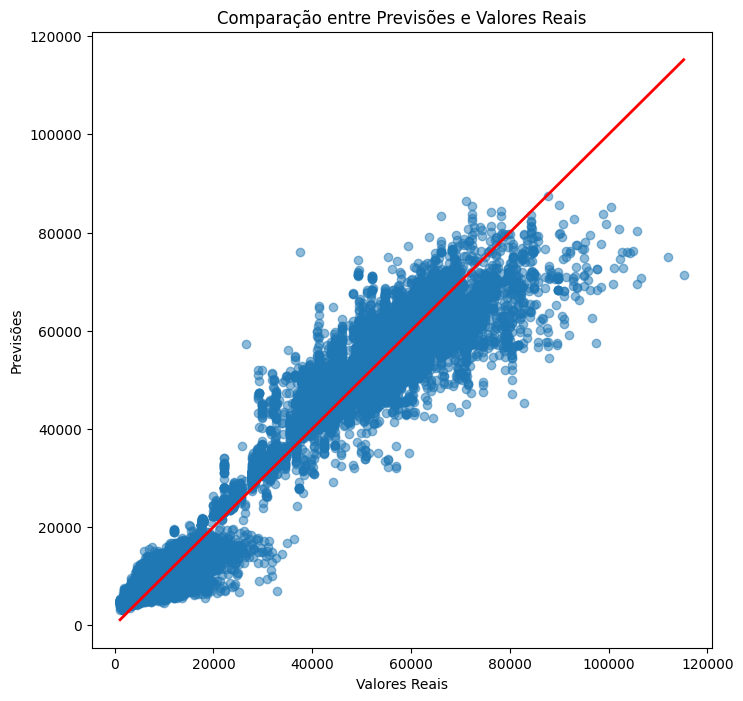

In [25]:
import matplotlib.pyplot as plt

# Plotar comparações entre previsões e valores reais
plt.figure(figsize=(8, 8))
plt.scatter(true_prices, predicted_prices, alpha=0.5)
plt.plot([min(true_prices), max(true_prices)], [min(true_prices), max(true_prices)], color='red', linewidth=2)
plt.title('Comparação entre Previsões e Valores Reais')
plt.xlabel('Valores Reais')
plt.ylabel('Previsões')
plt.show()


Teste 2 - Redução do decaimento do peso

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Inicializar modelo, critério de perda, otimizador e scheduler
input_dim = X_train_tensor.shape[1]
model = MLPRegressionModel(input_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Scheduler para ajuste dinâmico da taxa de aprendizado
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.1)

# Parada antecipada (Early Stopping)
patience = 15
best_val_loss = float('inf')
patience_counter = 0

# Função de avaliação
def evaluate_model(model, criterion, X_val_tensor, y_val_tensor):
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_mape = mean_absolute_percentage_error(y_val_tensor, val_outputs)
        val_accuracy = accuracy_within_tolerance(y_val_tensor, val_outputs, tolerance=0.2)
    return val_loss, val_mape, val_accuracy

# Loop de treinamento com augmentação e fine-tuning
epochs = 100

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    # Treinamento por mini-batches
    for X_batch, y_batch in train_loader:
        # Técnicas de augmentação
        if epoch % 3 == 0:
            # Aplicar MixUp
            X_aug, y_aug = mixup_data(X_batch, y_batch)
        else:
            # Aplicar Ruído Gaussiano
            X_aug = add_gaussian_noise(X_batch)
            y_aug = y_batch

        # Forward pass
        outputs = model(X_aug)
        loss = criterion(outputs, y_aug)

        # Backward pass e otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validação após cada época
    val_loss, val_mape, val_accuracy = evaluate_model(model, criterion, X_val_tensor, y_val_tensor)

    # Redução da taxa de aprendizado com scheduler
    scheduler.step(val_loss)

    # Verificação do early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Salvar o modelo com melhor validação
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

    # Exibir resultados a cada 10 épocas
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}], Loss: {running_loss / len(train_loader):.4f}, '
              f'Val Loss: {val_loss.item():.4f}, Val MAPE: {val_mape.item():.2f}%, '
              f'Val Accuracy: {val_accuracy * 100:.2f}%')

# Avaliação no conjunto de teste
model.load_state_dict(torch.load('best_model.pth', weights_only=True))
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_loss = criterion(test_predictions, y_test_tensor)
    test_mape = mean_absolute_percentage_error(y_test_tensor, test_predictions)
    test_accuracy = accuracy_within_tolerance(y_test_tensor, test_predictions, tolerance=0.1)

    print(f'Test Loss: {test_loss.item():.4f}, Test MAPE: {test_mape.item():.2f}%, '
          f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Avaliação no conjunto de teste original (sem augmentação)
model.eval()  # Coloca o modelo em modo de avaliação
with torch.no_grad():  # Desativa o autograd para não computar gradientes durante a inferência
    test_predictions = model(X_test_tensor)  # Realiza as previsões no conjunto de teste
    test_loss = criterion(test_predictions, y_test_tensor)  # Calcula a perda no teste (MSE)
    test_mape = mean_absolute_percentage_error(y_test_tensor, test_predictions)  # Calcula o MAPE
    test_accuracy = accuracy_within_tolerance(y_test_tensor, test_predictions, tolerance=0.1)  # Calcula a acurácia com tolerância de 10%

    # Exibe os resultados de avaliação
    print(f'Test Loss: {test_loss.item():.4f}, Test MAPE: {test_mape.item():.2f}%, '
          f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Inverter a normalização para visualizar os resultados na escala original
predicted_prices = scaler_y.inverse_transform(test_predictions.cpu().numpy())  # Inverte a normalização das previsões
true_prices = scaler_y.inverse_transform(y_test_tensor.cpu().numpy())  # Inverte a normalização dos valores reais

# Exibir algumas previsões vs valores reais para comparação
print("Previsões vs. Valores Reais (após normalização inversa):")
for i in range(10):
    print(f"Predicted: {predicted_prices[i][0]:.2f}, True: {true_prices[i][0]:.2f}")


Epoch [10], Loss: 0.0415, Val Loss: 0.0489, Val MAPE: 39.31%, Val Accuracy: 49.24%
Epoch [20], Loss: 0.0387, Val Loss: 0.0408, Val MAPE: 38.81%, Val Accuracy: 81.16%
Epoch [30], Loss: 0.0340, Val Loss: 0.0358, Val MAPE: 35.33%, Val Accuracy: 81.55%
Epoch [40], Loss: 0.0367, Val Loss: 0.0370, Val MAPE: 35.03%, Val Accuracy: 78.40%
Epoch [50], Loss: 0.0333, Val Loss: 0.0333, Val MAPE: 32.86%, Val Accuracy: 81.08%


In [ ]:
import matplotlib.pyplot as plt

# Plotar comparações entre previsões e valores reais
plt.figure(figsize=(8, 8))
plt.scatter(true_prices, predicted_prices, alpha=0.5)
plt.plot([min(true_prices), max(true_prices)], [min(true_prices), max(true_prices)], color='red', linewidth=2)
plt.title('Comparação entre Previsões e Valores Reais')
plt.xlabel('Valores Reais')
plt.ylabel('Previsões')
plt.show()


Teste 3 - Redução no tamanho da rede neural

In [ ]:
import torch.nn as nn
# Definindo arquitetura do modelo

class MLPRegressionModel(nn.Module):
  def __init__(self, input_dim):
    super(MLPRegressionModel, self).__init__()
    self.fc1 = nn.Linear(input_dim, 64)
    self.relu1 = nn.ReLU()
    self.dropout1 = nn.Dropout(0.3)

    self.fc2 = nn.Linear(64, 32)
    self.relu2 = nn.ReLU()
    self.dropout2 =  nn.Dropout(0.3)

    self.fc3 = nn.Linear(32, 16)
    self.relu3 = nn.ReLU()

    self.fc4 = nn.Linear(16, 1)

  def forward(self, x):
    x = self.fc1(x)
    x = self.relu1(x)
    x = self.dropout1(x)

    x = self.fc2(x)
    x = self.relu2(x)
    x = self.dropout2(x)

    x = self.fc3(x)
    x = self.relu3(x)

    x = self.fc4(x)
    return x

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Inicializar modelo, critério de perda, otimizador e scheduler
input_dim = X_train_tensor.shape[1]
model = MLPRegressionModel(input_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Scheduler para ajuste dinâmico da taxa de aprendizado
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.1)

# Parada antecipada (Early Stopping)
patience = 15
best_val_loss = float('inf')
patience_counter = 0

# Função de avaliação
def evaluate_model(model, criterion, X_val_tensor, y_val_tensor):
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_mape = mean_absolute_percentage_error(y_val_tensor, val_outputs)
        val_accuracy = accuracy_within_tolerance(y_val_tensor, val_outputs, tolerance=0.2)
    return val_loss, val_mape, val_accuracy

# Loop de treinamento com augmentação e fine-tuning
epochs = 100

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    # Treinamento por mini-batches
    for X_batch, y_batch in train_loader:
        # Técnicas de augmentação
        if epoch % 3 == 0:
            # Aplicar MixUp
            X_aug, y_aug = mixup_data(X_batch, y_batch)
        else:
            # Aplicar Ruído Gaussiano
            X_aug = add_gaussian_noise(X_batch)
            y_aug = y_batch

        # Forward pass
        outputs = model(X_aug)
        loss = criterion(outputs, y_aug)

        # Backward pass e otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validação após cada época
    val_loss, val_mape, val_accuracy = evaluate_model(model, criterion, X_val_tensor, y_val_tensor)

    # Redução da taxa de aprendizado com scheduler
    scheduler.step(val_loss)

    # Verificação do early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Salvar o modelo com melhor validação
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

    # Exibir resultados a cada 10 épocas
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}], Loss: {running_loss / len(train_loader):.4f}, '
              f'Val Loss: {val_loss.item():.4f}, Val MAPE: {val_mape.item():.2f}%, '
              f'Val Accuracy: {val_accuracy * 100:.2f}%')

# Avaliação no conjunto de teste
model.load_state_dict(torch.load('best_model.pth', weights_only=True))
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_loss = criterion(test_predictions, y_test_tensor)
    test_mape = mean_absolute_percentage_error(y_test_tensor, test_predictions)
    test_accuracy = accuracy_within_tolerance(y_test_tensor, test_predictions, tolerance=0.1)

    print(f'Test Loss: {test_loss.item():.4f}, Test MAPE: {test_mape.item():.2f}%, '
          f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Avaliação no conjunto de teste original (sem augmentação)
model.eval()  # Coloca o modelo em modo de avaliação
with torch.no_grad():  # Desativa o autograd para não computar gradientes durante a inferência
    test_predictions = model(X_test_tensor)  # Realiza as previsões no conjunto de teste
    test_loss = criterion(test_predictions, y_test_tensor)  # Calcula a perda no teste (MSE)
    test_mape = mean_absolute_percentage_error(y_test_tensor, test_predictions)  # Calcula o MAPE
    test_accuracy = accuracy_within_tolerance(y_test_tensor, test_predictions, tolerance=0.1)  # Calcula a acurácia com tolerância de 10%

    # Exibe os resultados de avaliação
    print(f'Test Loss: {test_loss.item():.4f}, Test MAPE: {test_mape.item():.2f}%, '
          f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Inverter a normalização para visualizar os resultados na escala original
predicted_prices = scaler_y.inverse_transform(test_predictions.cpu().numpy())  # Inverte a normalização das previsões
true_prices = scaler_y.inverse_transform(y_test_tensor.cpu().numpy())  # Inverte a normalização dos valores reais

# Exibir algumas previsões vs valores reais para comparação
print("Previsões vs. Valores Reais (após normalização inversa):")
for i in range(10):
    print(f"Predicted: {predicted_prices[i][0]:.2f}, True: {true_prices[i][0]:.2f}")


In [ ]:
import matplotlib.pyplot as plt

# Plotar comparações entre previsões e valores reais
plt.figure(figsize=(8, 8))
plt.scatter(true_prices, predicted_prices, alpha=0.5)
plt.plot([min(true_prices), max(true_prices)], [min(true_prices), max(true_prices)], color='red', linewidth=2)
plt.title('Comparação entre Previsões e Valores Reais')
plt.xlabel('Valores Reais')
plt.ylabel('Previsões')
plt.show()


Teste 4 - Aumento do Dropout

In [ ]:
import torch.nn as nn
# Definindo arquitetura do modelo

class MLPRegressionModel(nn.Module):
  def __init__(self, input_dim):
    super(MLPRegressionModel, self).__init__()
    self.fc1 = nn.Linear(input_dim, 128)
    self.relu1 = nn.ReLU()
    self.dropout1 = nn.Dropout(0.4)

    self.fc2 = nn.Linear(128, 64)
    self.relu2 = nn.ReLU()
    self.dropout2 =  nn.Dropout(0.4)

    self.fc3 = nn.Linear(64, 32)
    self.relu3 = nn.ReLU()

    self.fc4 = nn.Linear(32, 1)

  def forward(self, x):
    x = self.fc1(x)
    x = self.relu1(x)
    x = self.dropout1(x)

    x = self.fc2(x)
    x = self.relu2(x)
    x = self.dropout2(x)

    x = self.fc3(x)
    x = self.relu3(x)

    x = self.fc4(x)
    return x

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Inicializar modelo, critério de perda, otimizador e scheduler
input_dim = X_train_tensor.shape[1]
model = MLPRegressionModel(input_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Scheduler para ajuste dinâmico da taxa de aprendizado
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.1)

# Parada antecipada (Early Stopping)
patience = 15
best_val_loss = float('inf')
patience_counter = 0

# Função de avaliação
def evaluate_model(model, criterion, X_val_tensor, y_val_tensor):
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_mape = mean_absolute_percentage_error(y_val_tensor, val_outputs)
        val_accuracy = accuracy_within_tolerance(y_val_tensor, val_outputs, tolerance=0.2)
    return val_loss, val_mape, val_accuracy

# Loop de treinamento com augmentação e fine-tuning
epochs = 100

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    # Treinamento por mini-batches
    for X_batch, y_batch in train_loader:
        # Técnicas de augmentação
        if epoch % 3 == 0:
            # Aplicar MixUp
            X_aug, y_aug = mixup_data(X_batch, y_batch)
        else:
            # Aplicar Ruído Gaussiano
            X_aug = add_gaussian_noise(X_batch)
            y_aug = y_batch

        # Forward pass
        outputs = model(X_aug)
        loss = criterion(outputs, y_aug)

        # Backward pass e otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validação após cada época
    val_loss, val_mape, val_accuracy = evaluate_model(model, criterion, X_val_tensor, y_val_tensor)

    # Redução da taxa de aprendizado com scheduler
    scheduler.step(val_loss)

    # Verificação do early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Salvar o modelo com melhor validação
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

    # Exibir resultados a cada 10 épocas
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}], Loss: {running_loss / len(train_loader):.4f}, '
              f'Val Loss: {val_loss.item():.4f}, Val MAPE: {val_mape.item():.2f}%, '
              f'Val Accuracy: {val_accuracy * 100:.2f}%')

# Avaliação no conjunto de teste
model.load_state_dict(torch.load('best_model.pth', weights_only=True))
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_loss = criterion(test_predictions, y_test_tensor)
    test_mape = mean_absolute_percentage_error(y_test_tensor, test_predictions)
    test_accuracy = accuracy_within_tolerance(y_test_tensor, test_predictions, tolerance=0.1)

    print(f'Test Loss: {test_loss.item():.4f}, Test MAPE: {test_mape.item():.2f}%, '
          f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Avaliação no conjunto de teste original (sem augmentação)
model.eval()  # Coloca o modelo em modo de avaliação
with torch.no_grad():  # Desativa o autograd para não computar gradientes durante a inferência
    test_predictions = model(X_test_tensor)  # Realiza as previsões no conjunto de teste
    test_loss = criterion(test_predictions, y_test_tensor)  # Calcula a perda no teste (MSE)
    test_mape = mean_absolute_percentage_error(y_test_tensor, test_predictions)  # Calcula o MAPE
    test_accuracy = accuracy_within_tolerance(y_test_tensor, test_predictions, tolerance=0.1)  # Calcula a acurácia com tolerância de 10%

    # Exibe os resultados de avaliação
    print(f'Test Loss: {test_loss.item():.4f}, Test MAPE: {test_mape.item():.2f}%, '
          f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Inverter a normalização para visualizar os resultados na escala original
predicted_prices = scaler_y.inverse_transform(test_predictions.cpu().numpy())  # Inverte a normalização das previsões
true_prices = scaler_y.inverse_transform(y_test_tensor.cpu().numpy())  # Inverte a normalização dos valores reais

# Exibir algumas previsões vs valores reais para comparação
print("Previsões vs. Valores Reais (após normalização inversa):")
for i in range(10):
    print(f"Predicted: {predicted_prices[i][0]:.2f}, True: {true_prices[i][0]:.2f}")


In [ ]:
import matplotlib.pyplot as plt

# Plotar comparações entre previsões e valores reais
plt.figure(figsize=(8, 8))
plt.scatter(true_prices, predicted_prices, alpha=0.5)
plt.plot([min(true_prices), max(true_prices)], [min(true_prices), max(true_prices)], color='red', linewidth=2)
plt.title('Comparação entre Previsões e Valores Reais')
plt.xlabel('Valores Reais')
plt.ylabel('Previsões')
plt.show()
